<a href="https://colab.research.google.com/github/hanifabd/HandGesture-Classification-Using-TensorFlow/blob/main/HandGesture_Classification_Using_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Hanif Yuli Abdillah P
# hanifabd23@gmail.com

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2020-10-08 13:12:36--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  9.67MB/s    in 39s     

2020-10-08 13:13:16 (7.99 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

data_dir = '/tmp/rockpaperscissors/rps-cv-images'

In [ ]:
train_datagen = ImageDataGenerator( 
    rescale = 1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    validation_split=0.4
    )

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.4
    )

train_generator = train_datagen.flow_from_directory(
    data_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(40, 60),
    subset='training'
    )

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(40, 60),
    subset='validation'
    )

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(40, 60, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='Same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 36, 56, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 56, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 56, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 14, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16128)             0

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy', f1]
    )

In [ ]:
saved_model = 'best_model.h5'

checkpoint_callback = ModelCheckpoint(
    saved_model,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1)

reduce_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    factor=0.5,
    min_lr=0.000003,
    verbose=1)

In [ ]:
startAt = time.time()
model_history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 25,
    batch_size=32,
    verbose = 2,
    callbacks=[checkpoint_callback,reduce_callback],
)
endAt = time.time()

Epoch 1/25

Epoch 00001: val_accuracy improved from -inf to 0.59840, saving model to best_model.h5
42/42 - 35s - loss: 1.3493 - accuracy: 0.4528 - f1: 0.2485 - val_loss: 1.0796 - val_accuracy: 0.5984 - val_f1: 0.0000e+00
Epoch 2/25

Epoch 00002: val_accuracy did not improve from 0.59840
42/42 - 34s - loss: 0.6625 - accuracy: 0.7428 - f1: 0.7199 - val_loss: 1.0903 - val_accuracy: 0.3318 - val_f1: 0.3403
Epoch 3/25

Epoch 00003: val_accuracy improved from 0.59840 to 0.85011, saving model to best_model.h5
42/42 - 34s - loss: 0.3539 - accuracy: 0.8661 - f1: 0.8653 - val_loss: 0.6981 - val_accuracy: 0.8501 - val_f1: 0.6985
Epoch 4/25

Epoch 00004: val_accuracy improved from 0.85011 to 0.86613, saving model to best_model.h5
42/42 - 34s - loss: 0.2276 - accuracy: 0.9186 - f1: 0.9194 - val_loss: 0.6136 - val_accuracy: 0.8661 - val_f1: 0.7826
Epoch 5/25

Epoch 00005: val_accuracy improved from 0.86613 to 0.91419, saving model to best_model.h5
42/42 - 34s - loss: 0.1905 - accuracy: 0.9323 - f1: 

In [ ]:
print('execution time : '+ str((endAt-startAt)/60))

execution time : 14.663206573327383


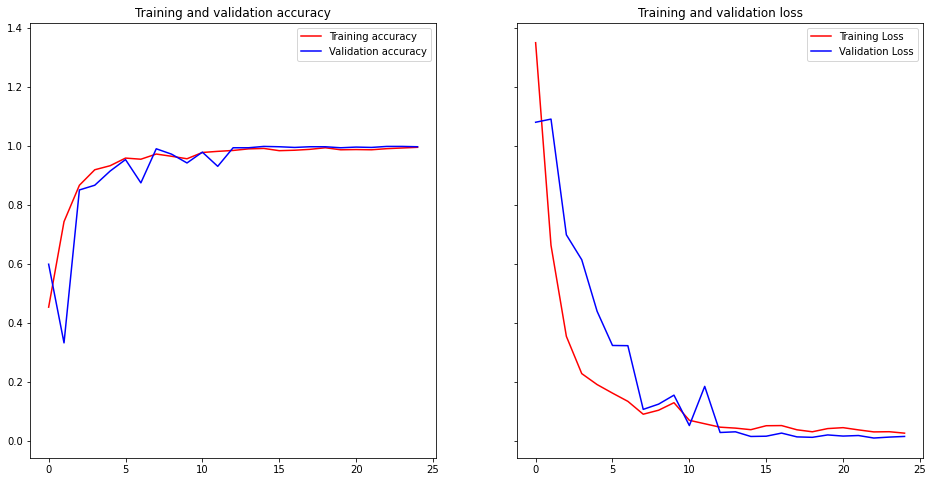

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(1,2, sharey=True, figsize=(16,8))

ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

In [ ]:
model.load_weights(saved_model)
testing_model = model.evaluate_generator(validation_generator, 874 // 32, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
27/27 [==============================] - 6s 211ms/step - loss: 0.0147 - accuracy: 0.9977 - f1: 0.9977


In [ ]:
print('Accuracy on Validation Data: ' + str(int(testing_model[1] * 10000) / 100) + '%')

Accuracy on Validation Data: 99.76%


In [ ]:
# fn = '/tmp/rockpaperscissors/paper/Wcg4nsnlWrhxgyJg.png'
# fn = '/tmp/rockpaperscissors/rock/qiysAN26ClLYOZfG.png'
fn = '/tmp/rockpaperscissors/scissors/JDuoo6aDjbIAqA4X.png'

/tmp/rockpaperscissors/scissors/JDuoo6aDjbIAqA4X.png
scissors


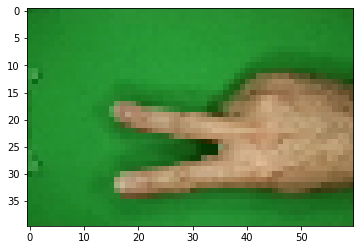

In [ ]:
# predicting images
path = fn
img = image.load_img(path, target_size=(40,60))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
 
images = np.vstack([x])
classes = model.predict(images, batch_size=32)
classes = int(classes.argmax(axis=-1))
print(fn)
# print(classes)
if classes==0:
  print('paper')
elif classes==1:
  print('rock')
else:
  print('scissors')